# RESEGMENTATION PIPELINE

## Set up source and destination folders

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box


In [2]:
ddir = 'D:\Alexis\Projects\SpatialOmics_cellpose\\results'
base_path = "D:\Alexis\Projects\SpatialOmics_cellpose\data5k_r2\output-XETG00245__0054802__1887_OD__20250501__171736"
# Select first and third hannels for segmentation (can only select two) 
fullres_chanel_0 = f"{base_path}\morphology_focus\morphology_focus_0000.ome.tif"   
fullres_chanel_2 = f"{base_path}\morphology_focus\morphology_focus_0002.ome.tif"
sample_name = "1887od"
ROI_filepath = f"{base_path}\{sample_name}_coords.csv"

# Levels: pixelsize in µm https://kb.10xgenomics.com/hc/en-us/articles/11636252598925
scalefactors = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2,
}

# Define resolution level and crop size in pixels
level = 0
pixelsize = scalefactors[level]

# Define patch size
crop_size = 600/pixelsize

## Define the region of interest (ROI)

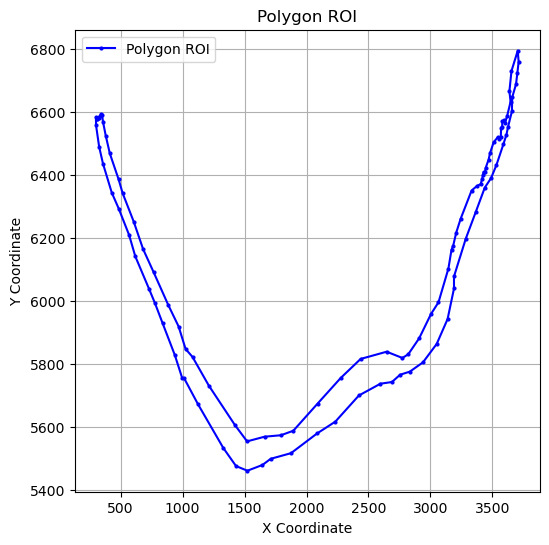

In [3]:
# Read the ROI coordinates from the CSV file
from SRC_RESEG.crop_image import *
plot_roi(ROI_filepath)
polygon_coords = pd.read_csv(ROI_filepath)
# Extract the X and Y coordinates
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']


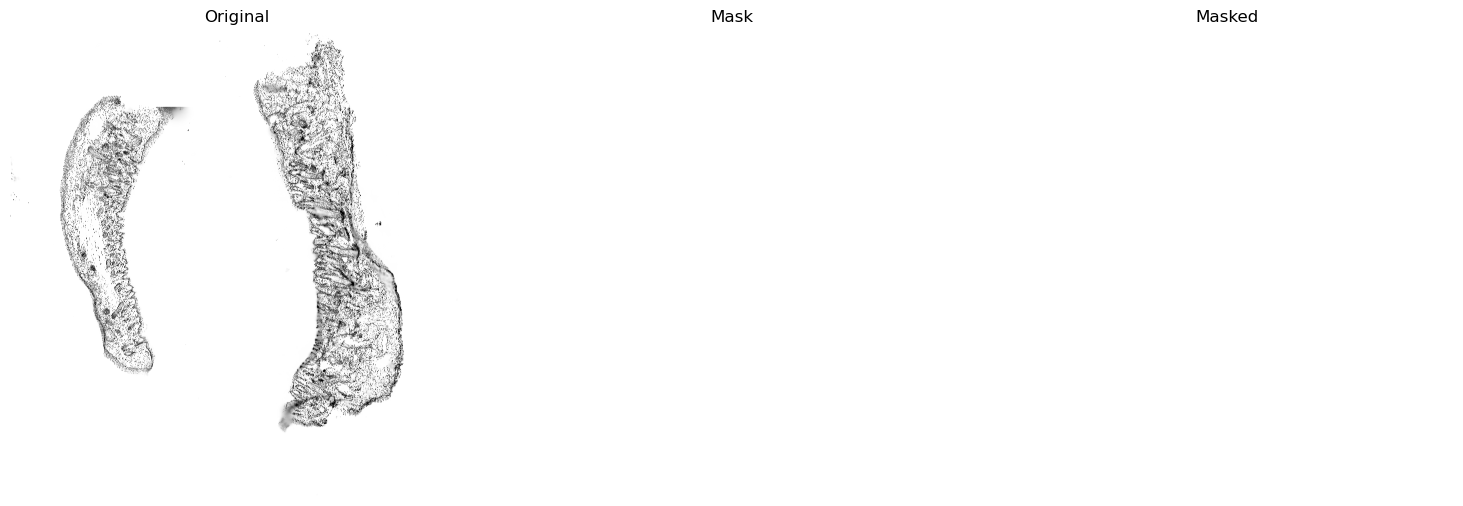

In [4]:
mask, masked_img_0 = mask_polygon_from_tif(
    fullres_chanel_0,
    x_coords, y_coords,
    scalefactors,
    level=0,
    plot=True
)

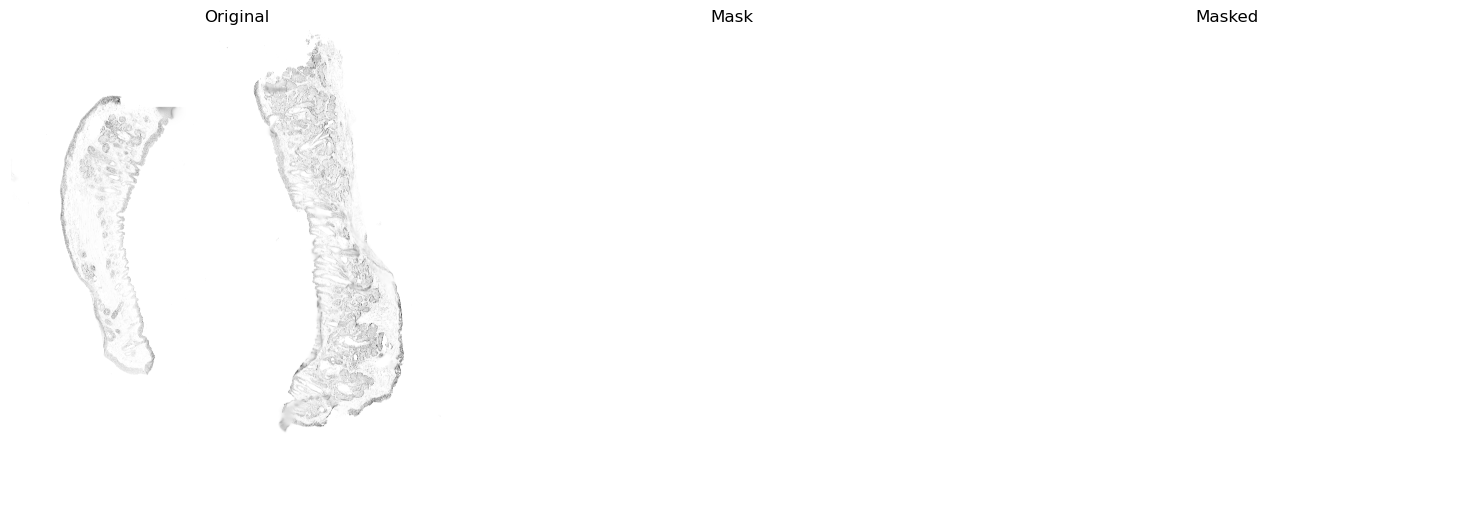

In [5]:
mask, masked_img_2 = mask_polygon_from_tif(
    fullres_chanel_2,
    x_coords, y_coords,
    scalefactors,
    level=0,
    plot=True
)

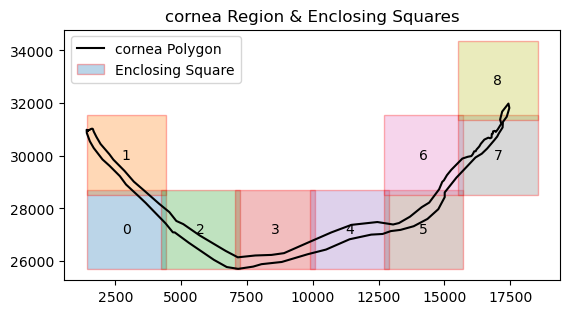

In [6]:
# Combine X and Y into coordinate pairs
x_coords_rescaled = x_coords / pixelsize
y_coords_rescaled = y_coords / pixelsize
rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))

# Create a Polygon object
rescaled_polygon_roi = Polygon(rescaled_polygon_roi)

# Define square size
square_size = int(crop_size)
overlap_size = 40/0.2125

# Generate non-overlapping square regions
overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, overlap_size=overlap_size, with_overlap=True)
non_overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, with_overlap=False)


plot_polygon_and_squares(
    rescaled_polygon_roi,
    overlapping_squares,
    title="cornea Region & Enclosing Squares",
    polygon_label="cornea Polygon",
    square_label="Enclosing Square"
)

# for square in overlapping_squares:
#     print("square:", square)
#     x, y = square.exterior.xy
#     print(" x:", x,"\n", "y:", y)


In [7]:
import os

In [8]:
# Process and plot the square regions
for i, square in enumerate(overlapping_squares):
    print(f"Processing square {i + 1}:", square)
    
    # ch 0 Crop the region 
    cropped_image_sub = crop_region(masked_img_0, square)
    # ch2 Crop the region
    cropped_image_sub2 = crop_region(masked_img_2, square)
    cropped_image_sub_combined = np.stack((cropped_image_sub, cropped_image_sub2), axis=0)


    # Check if the folder exists, if not create it
    save_dir = f"{ddir}/cropped_image/{sample_name}"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")

    # Save the cropped image
    save_path = f"{save_dir}/cropped_square_com_{i + 1}.tif"
    tifffile.imwrite(save_path, cropped_image_sub_combined)
    print(f"Cropped image saved to {save_path}")

Processing square 1: POLYGON ((4423.235294117647 25696, 4423.235294117647 28707.235294117647, 1412 28707.235294117647, 1412 25696, 4423.235294117647 25696))
Created directory: D:\Alexis\Projects\SpatialOmics_cellpose\results/cropped_image/1885od
Cropped image saved to D:\Alexis\Projects\SpatialOmics_cellpose\results/cropped_image/1885od/cropped_square_com_1.tif
Processing square 2: POLYGON ((4423.235294117647 28519, 4423.235294117647 31530.235294117647, 1412 31530.235294117647, 1412 28519, 4423.235294117647 28519))
Cropped image saved to D:\Alexis\Projects\SpatialOmics_cellpose\results/cropped_image/1885od/cropped_square_com_2.tif
Processing square 3: POLYGON ((7246.235294117647 25696, 7246.235294117647 28707.235294117647, 4235 28707.235294117647, 4235 25696, 7246.235294117647 25696))
Cropped image saved to D:\Alexis\Projects\SpatialOmics_cellpose\results/cropped_image/1885od/cropped_square_com_3.tif
Processing square 4: POLYGON ((10069.235294117647 25696, 10069.235294117647 28707.2352

d:\Alexis\miniforge\envs\cellpose_env\Lib\site-packages\tifffile\tifffile.py:2360: UserWarning: <tifffile.TiffWriter 'cropped_square_com_1.tif'> writing zero-size array to nonconformant TIFF
  warnings.warn(
d:\Alexis\miniforge\envs\cellpose_env\Lib\site-packages\tifffile\tifffile.py:2360: UserWarning: <tifffile.TiffWriter 'cropped_square_com_2.tif'> writing zero-size array to nonconformant TIFF
  warnings.warn(
d:\Alexis\miniforge\envs\cellpose_env\Lib\site-packages\tifffile\tifffile.py:2360: UserWarning: <tifffile.TiffWriter 'cropped_square_com_3.tif'> writing zero-size array to nonconformant TIFF
  warnings.warn(
d:\Alexis\miniforge\envs\cellpose_env\Lib\site-packages\tifffile\tifffile.py:2360: UserWarning: <tifffile.TiffWriter 'cropped_square_com_4.tif'> writing zero-size array to nonconformant TIFF
  warnings.warn(
d:\Alexis\miniforge\envs\cellpose_env\Lib\site-packages\tifffile\tifffile.py:2360: UserWarning: <tifffile.TiffWriter 'cropped_square_com_5.tif'> writing zero-size array

## CELLPOSE - SEGMENTATION

In [9]:
from SRC_RESEG.segmentation_cp import *




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	win32 
python version: 	3.11.10 
torch version:  	2.7.1+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [10]:
model = models.CellposeModel(gpu=True, 
                             pretrained_model='D:\Alexis\Projects\SpatialOmics_cellpose\models\cpsam_DED',
                             )

In [11]:
# Example usage
total = process_images_in_folder(
    input_folder = f'{ddir}/cropped_image/{sample_name}',      
    output_folder = f'{ddir}/segmenatation/{sample_name}',
    cellpose_model = model
)

print(f"Total cells detected: {total}")

Skipping cropped_square_com_1.tif due to invalid dimensions: (2, 0, 3011)
Skipping cropped_square_com_2.tif due to invalid dimensions: (2, 0, 3011)
Skipping cropped_square_com_3.tif due to invalid dimensions: (2, 0, 3011)
Skipping cropped_square_com_4.tif due to invalid dimensions: (2, 0, 3011)
Skipping cropped_square_com_5.tif due to invalid dimensions: (2, 0, 3011)
Skipping cropped_square_com_6.tif due to invalid dimensions: (2, 0, 3011)
Skipping cropped_square_com_7.tif due to invalid dimensions: (2, 0, 3011)
Skipping cropped_square_com_8.tif due to invalid dimensions: (2, 0, 3011)
Skipping cropped_square_com_9.tif due to invalid dimensions: (2, 0, 3011)
Total cells detected: 0


## Merge

In [12]:
from SRC_RESEG.merge import *

In [13]:
ROI_filepath = f"{base_path}\{sample_name}_coords.csv"

In [14]:
input_dir = f"{ddir}/segmenatation/{sample_name}"

# 1. Load and offset centroids
centroids_dict = load_and_offset_centroids(input_dir, overlapping_squares)

# 2. Map centroids and get cell mapping
mapped_df, outside_df, cell_mapping = map_centroids_to_nonoverlapping(centroids_dict, non_overlapping_squares)

# 3. Load and map outlines
filtered_outlines_list, outline_info = map_and_filter_outlines(input_dir, overlapping_squares, cell_mapping)



Found 0 centroid files

Found files:


ValueError: No valid centroid files were processed!

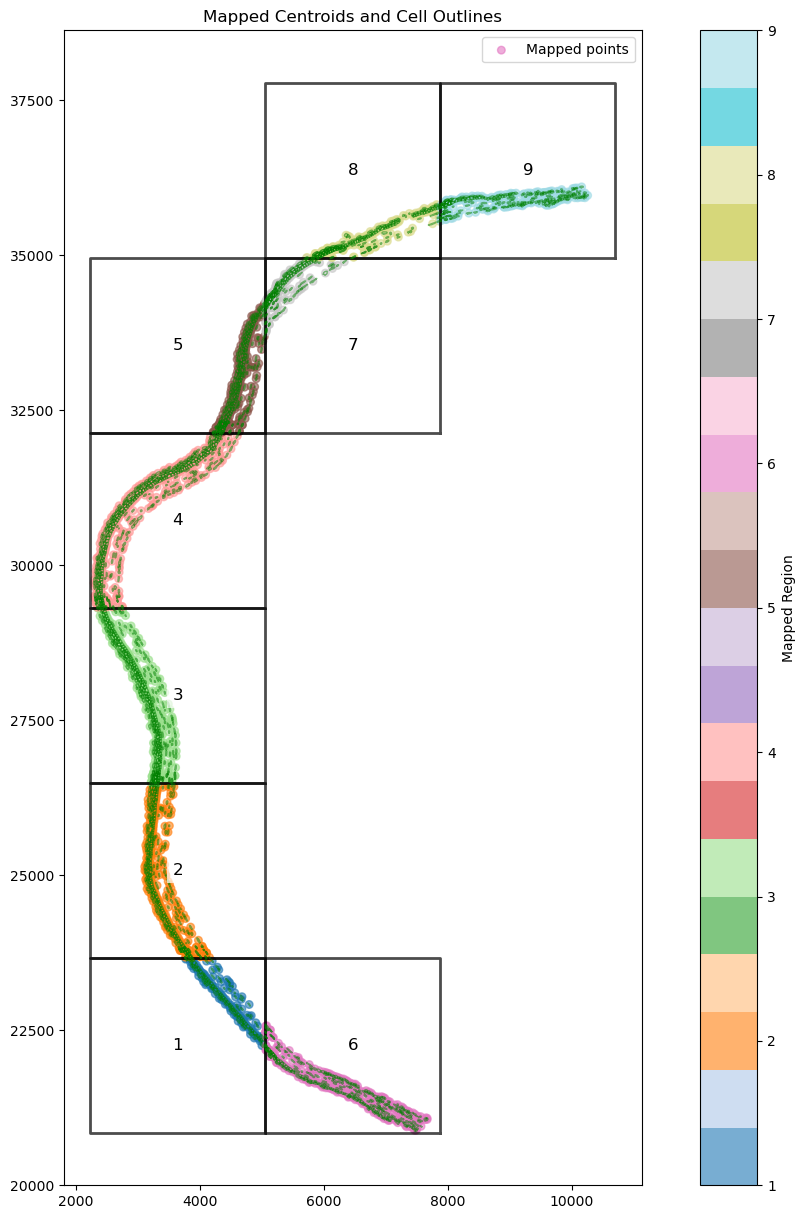


Results saved to: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1874os


In [15]:
# 4. Visualize results
visualize_mapped_data(mapped_df, outside_df, filtered_outlines_list, non_overlapping_squares)

# 5. Save results
output_dir = input_dir
mapped_df.to_csv(os.path.join(output_dir, 'mapped_centroids.csv'), index=False)
if not outside_df.empty:
    outside_df.to_csv(os.path.join(output_dir, 'unmapped_centroids.csv'), index=False)
outline_info.to_csv(os.path.join(output_dir, 'outline_mapping.csv'), index=False)
print(f"\nResults saved to: {output_dir}")

In [16]:
# Function to map segmentation outlines back to original coordinates
def map_to_original_coordinates(outlines, offset):

    min_x, min_y = offset
    
    return [outline + np.array([min_x, min_y]) for outline in outlines]

outlines_list = []


# Example processing loop for 3 cropped regions
for i, square in enumerate(overlapping_squares):
    
    # Stop the loop when i = 30 if 6 picture, set i + 1 = 5
    if i + 1 == 29:
        i1 = i + 1
        print("Reached the stopping condition: number = {i1}. Exiting the loop.")
        break

    print(f"Processing square {i + 1}: {square}")
    
    # Get bounding box of the current polygon (cropped region)
    min_x, min_y, max_x, max_y = map(int, square.bounds)

    # Load the segmentation result for the cropped region
    # segmentation_file = f"{ddir}/segmenatation/{sample_name}/cropped_square_com_{i + 1}_seg.npy"
    segmentation_file = f"{ddir}/segmenatation/{sample_name}/cropped_square_com_{i + 1}_seg.npy"
    segmentation_data = np.load(segmentation_file, allow_pickle=True).item()
    
    # Extract outlines from    the segmentation
    outlines = utils.outlines_list(segmentation_data['masks'])

    # Map outlines back to original coordinates
    mapped_outlines = map_to_original_coordinates(outlines, (min_x, min_y))
    outlines_list.extend(mapped_outlines)

Processing square 1: POLYGON ((5241.235294117647 20842, 5241.235294117647 23853.235294117647, 2230 23853.235294117647, 2230 20842, 5241.235294117647 20842))
Processing square 2: POLYGON ((5241.235294117647 23665, 5241.235294117647 26676.235294117647, 2230 26676.235294117647, 2230 23665, 5241.235294117647 23665))
Processing square 3: POLYGON ((5241.235294117647 26488, 5241.235294117647 29499.235294117647, 2230 29499.235294117647, 2230 26488, 5241.235294117647 26488))
Processing square 4: POLYGON ((5241.235294117647 29311, 5241.235294117647 32322.235294117647, 2230 32322.235294117647, 2230 29311, 5241.235294117647 29311))
Processing square 5: POLYGON ((5241.235294117647 32134, 5241.235294117647 35145.23529411765, 2230 35145.23529411765, 2230 32134, 5241.235294117647 32134))
Processing square 6: POLYGON ((8064.235294117647 20842, 8064.235294117647 23853.235294117647, 5053 23853.235294117647, 5053 20842, 8064.235294117647 20842))
Processing square 7: POLYGON ((8064.235294117647 32134, 8064

In [17]:
 # reuse previous function

In [18]:
df_outlines_list = boundaries_to_table(outlines_list)

import pandas as pd

def close_cell_boundaries(df):
    closed_df = []

    for cell_id, group in df.groupby('cell_id'):
        group_closed = pd.concat([group, group.iloc[[0]]])  # Append first row at end
        closed_df.append(group_closed)

    return pd.concat(closed_df).reset_index(drop=True)

df_outlines_list = close_cell_boundaries(df_outlines_list)



In [19]:
df_outlines_list.to_csv(f"{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_origian_{sample_name}.csv", index=False)
print("Saved successly" )

Saved successly


In [20]:
# Apply the function
reduced_outlines_list = reduce_points(df_outlines_list)

# Print the results
print("Original shape:", df_outlines_list.shape)
print("Reduced shape:", reduced_outlines_list.shape)

Original shape: (299544, 3)
Reduced shape: (191480, 3)


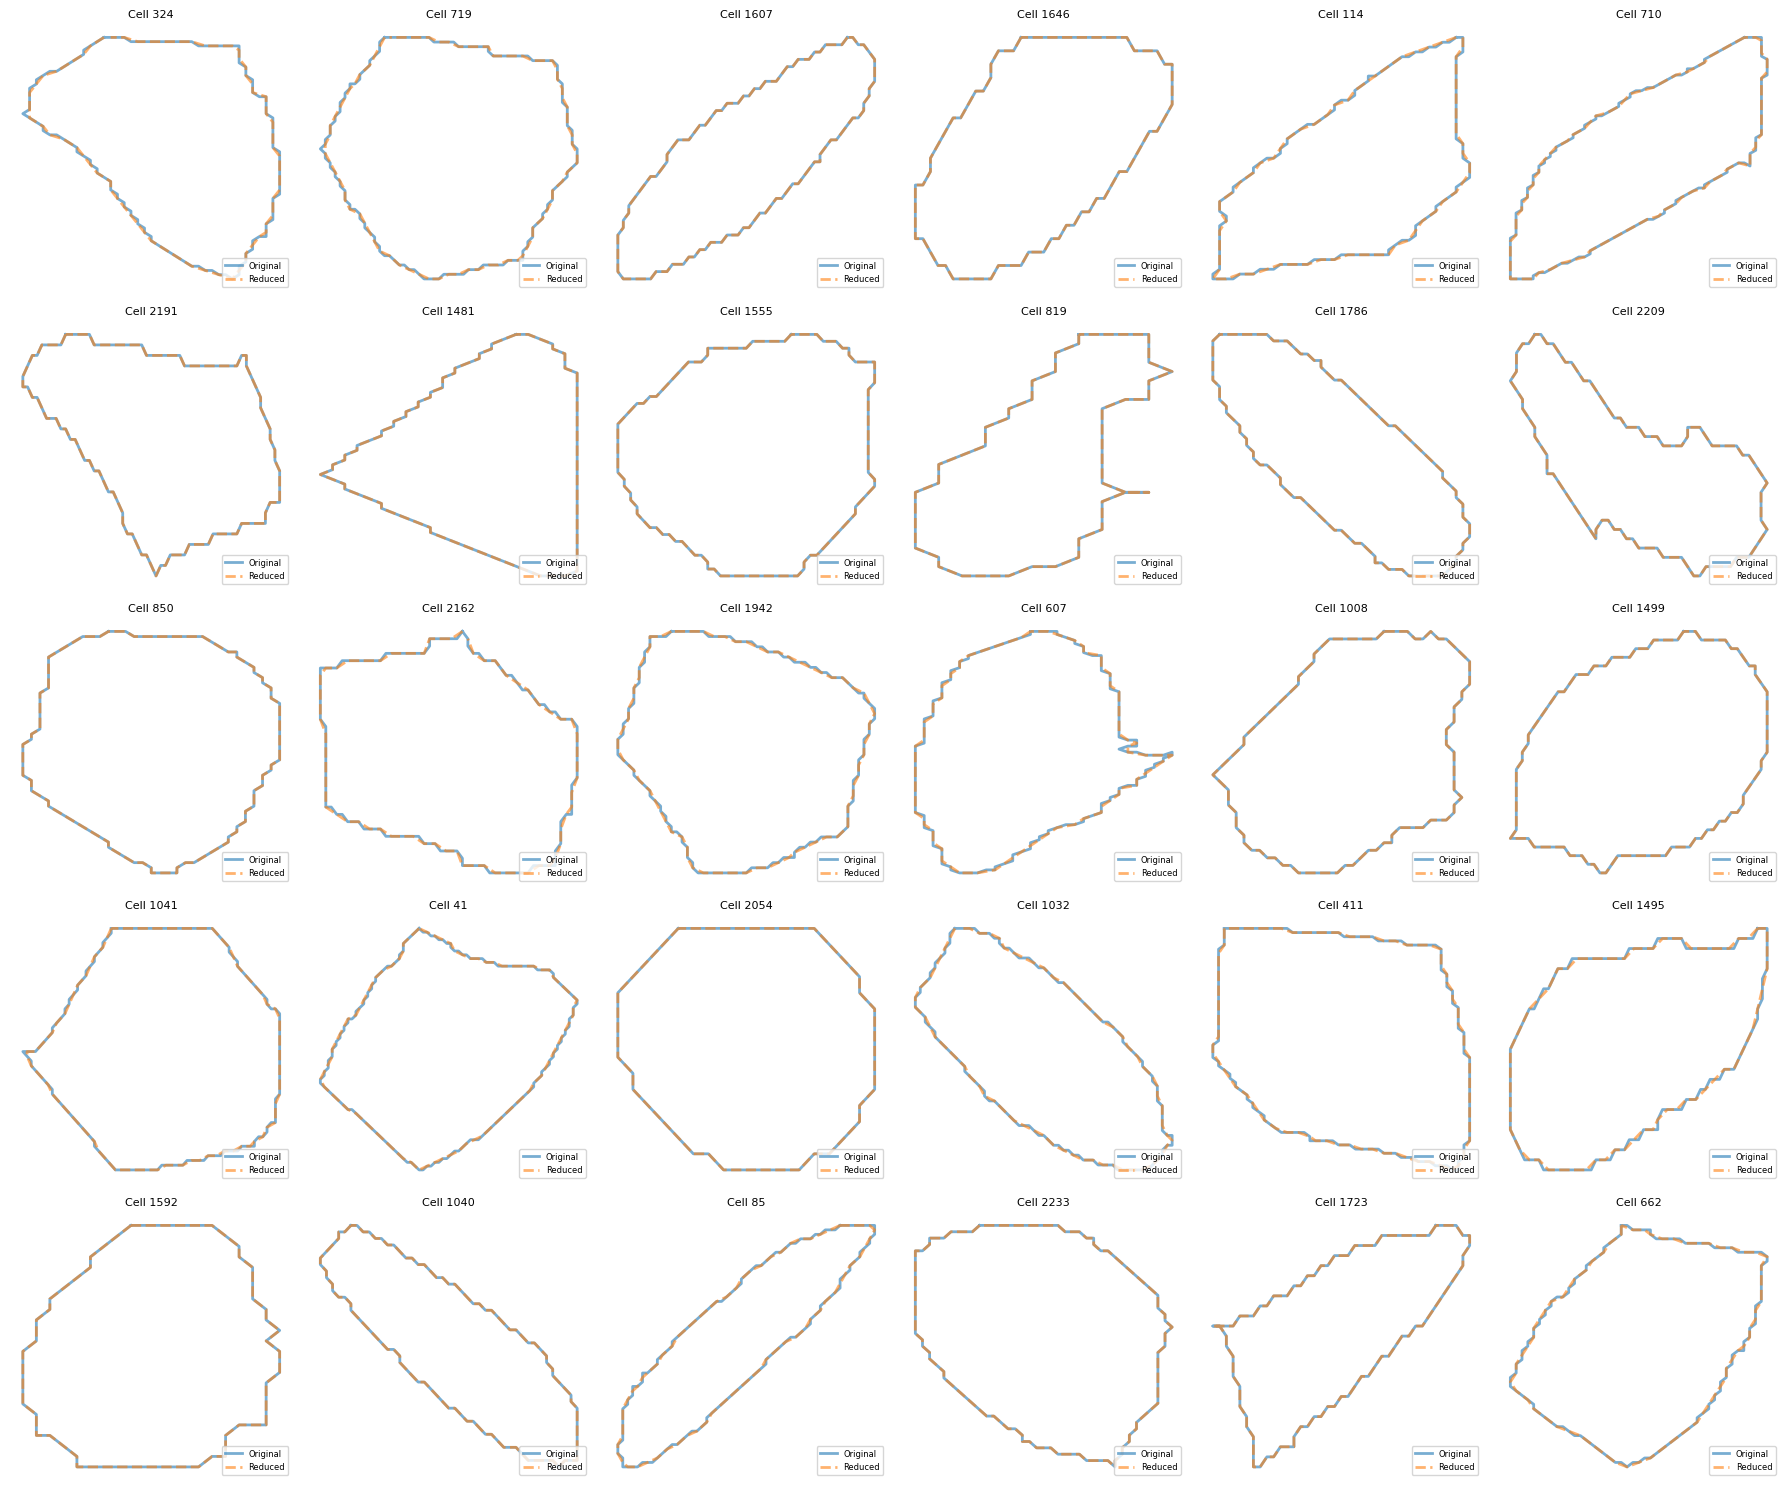

In [21]:
# Visulize before reduce size
import matplotlib.pyplot as plt
import numpy as np

def plot_cell_outlines_comparison(df_orig, df_reduced, n=30, rows=5, cols=6):
    # find cell IDs present in both dataframes
    common_ids = np.intersect1d(df_orig['cell_id'].unique(),
                                df_reduced['cell_id'].unique())
    # sample up to n cells
    ids = np.random.choice(common_ids, min(n, len(common_ids)), replace=False)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()
    for ax, cell_id in zip(axes, ids):
        orig = df_orig[df_orig['cell_id'] == cell_id]
        red  = df_reduced[df_reduced['cell_id'] == cell_id]

        # original outline
        ax.plot(orig['vertex_x'], orig['vertex_y'],
                linewidth=2, label='Original', alpha=0.6)
        # reduced outline
        ax.plot(red['vertex_x'],  red['vertex_y'],
                linewidth=2, linestyle='--', label='Reduced', alpha=0.6)

        ax.set_title(f'Cell {cell_id}', fontsize=8)
        ax.invert_yaxis()
        ax.axis('off')
        ax.legend(loc='lower right', fontsize=6)

    # turn off any extra axes
    for ax in axes[len(ids):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# usage
plot_cell_outlines_comparison(df_outlines_list, reduced_outlines_list)



In [22]:
reduced_outlines_list.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


In [23]:
unique_cell_count = reduced_outlines_list['cell_id'].nunique()
# unique_cell_count = boundary_df['cell_id'].nunique()

unique_cell_count

2298

In [24]:
# Calculate centroids for each cell
centroids_df = calculate_centroids(reduced_outlines_list)
centroids_df

,cell_id,centroid_x,centroid_y
0,1,5230.449438,21977.044944
1,2,5233.894118,22037.576471
2,3,5201.604651,22051.046512
3,4,5125.080645,22073.032258
4,5,5213.336538,22074.740385
...,...,...,...
2293,2294,10011.835165,36073.824176
2294,2295,10061.510870,36070.641304
2295,2296,10042.337079,36080.842697
2296,2297,10078.625000,36084.333333


In [25]:
centroids_df_scaled = centroids_df.copy()
rescale_factor = 0.2125
centroids_df_scaled['centroid_x'] *= rescale_factor
centroids_df_scaled['centroid_y'] *= rescale_factor

In [26]:
centroids_df_scaled.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_centroids_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


In [27]:
# Process to append the first row of each cell group
Outlines_list_final = (
    reduced_outlines_list.groupby('cell_id', group_keys=False)
    .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))
)

Outlines_list_final

C:\Users\Alexis\AppData\Local\Temp\ipykernel_14420\3904916442.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))


,cell_id,vertex_x,vertex_y
0,1,5238,21957
1,1,5237,21958
2,1,5236,21959
3,1,5235,21959
4,1,5234,21960
...,...,...,...
62,2298,10159,36090
63,2298,10157,36090
64,2298,10155,36090
65,2298,10153,36089


In [28]:
Outlines_list_final_scaled = Outlines_list_final.copy()
rescale_factor = 0.2125
Outlines_list_final_scaled['vertex_x'] *= rescale_factor
Outlines_list_final_scaled['vertex_y'] *= rescale_factor

In [29]:
Outlines_list_final.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_pixel_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


In [30]:
Outlines_list_final_scaled.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


## Assign Transcripts

In [31]:
import pandas as pd
boundaries_df_origin = pd.read_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}.csv')
print("Data boundaries table file successfully")

boundaries_df_origin

Data boundaries table file successfully


,cell_id,vertex_x,vertex_y
0,1,1113.0750,4665.8625
1,1,1112.8625,4666.0750
2,1,1112.6500,4666.2875
3,1,1112.4375,4666.2875
4,1,1112.2250,4666.5000
...,...,...,...
193773,2298,2158.7875,7669.1250
193774,2298,2158.3625,7669.1250
193775,2298,2157.9375,7669.1250
193776,2298,2157.5125,7668.9125


In [32]:
boundaries_df = boundaries_df_origin

In [33]:
transcripts_original = pd.read_parquet(f'{base_path}/transcripts.parquet')

# Print information about the data frame
transcripts_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61247123 entries, 0 to 61247122
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   transcript_id      uint64 
 1   cell_id            object 
 2   overlaps_nucleus   uint8  
 3   feature_name       object 
 4   x_location         float32
 5   y_location         float32
 6   z_location         float32
 7   qv                 float32
 8   fov_name           object 
 9   nucleus_distance   float32
 10  codeword_index     int32  
 11  codeword_category  object 
 12  is_gene            bool   
dtypes: bool(1), float32(5), int32(1), object(4), uint64(1), uint8(1)
memory usage: 3.8+ GB


In [ ]:
# Filter transcripts with qv score > 20
transcripts_b4_assign = transcripts_original[transcripts_original['qv'] > 20]

# Print information about the filtered dataframe
print("Original number of transcripts:", len(transcripts_original))
print("Number of transcripts after filtering (qv > 20):", len(transcripts_b4_assign))
print("\nPercentage of transcripts retained:", 
      round(len(transcripts_b4_assign) / len(transcripts_original) * 100, 2), "%")

# Display first few rows of filtered dataframe
print("\nFirst few rows of filtered data:")
print(transcripts_b4_assign.head())

Original number of transcripts: 61247123
Number of transcripts after filtering (qv > 20): 48664525

Percentage of transcripts retained: 79.46 %

First few rows of filtered data:
     transcript_id     cell_id  overlaps_nucleus feature_name  x_location  \
0  281646775422980  UNASSIGNED                 0     Ankrd13a   36.921875   
1  281646775417234  UNASSIGNED                 0       Bpifb1  106.046875   
2  281646775426306  UNASSIGNED                 0        Cpeb4  107.921875   
3  281646775421412  UNASSIGNED                 0       Dnajc5  118.562500   
4  281646775421672  UNASSIGNED                 0        Ecpas   30.187500   

   y_location  z_location     qv fov_name  nucleus_distance  codeword_index  \
0  734.453125   12.968750  37.25       W2        711.343750           10374   
1  740.812500   12.984375  40.00       W2        642.484375           17514   
2  738.750000   12.906250  26.50       W2        641.125000           11419   
3  748.187500   13.187500  40.00       W2  

In [35]:
processed_count = 0


In [36]:
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely.prepared import prep

# 1) Load your polygon
polygon_coords = pd.read_csv(f"{base_path}/{sample_name}_coords.csv")
polygon = Polygon(zip(polygon_coords['X'], polygon_coords['Y']))

# 2) Build the bounding‐box filter
minx, miny, maxx, maxy = polygon.bounds

# 3) Prepare the polygon for fast repeated contains() checks
prepared_poly = prep(polygon)

# 4) Load transcripts
df = transcripts_b4_assign.copy()

# 5) First, prefilter by bbox (very cheap)
mask_bbox = (
    (df["x_location"] >= minx) &
    (df["x_location"] <= maxx) &
    (df["y_location"] >= miny) &
    (df["y_location"] <= maxy)
)
df_bbox = df[mask_bbox]

print(f"{len(df_bbox)} of {len(df)} points lie in the bbox, now doing exact test…")

# 6) Now do the exact point-in-polygon test with a simple list comprehension
from tqdm import tqdm
filtered = []
for x, y in tqdm(zip(df_bbox["x_location"], df_bbox["y_location"]),
                 total=len(df_bbox)):
    pt = Point(x, y)
    if prepared_poly.contains(pt):
        filtered.append(True)
    else:
        filtered.append(False)

transcripts_filtered = df_bbox[filtered]
print(f"Kept {len(transcripts_filtered)} points inside the actual polygon.")


4393149 of 48664525 points lie in the bbox, now doing exact test…


100%|██████████| 4393149/4393149 [01:58<00:00, 36989.83it/s]


Kept 2553443 points inside the actual polygon.


In [ ]:
transcripts_filtered

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
231265,281539401487731,UNASSIGNED,0,2610528A11Rik,496.437500,6243.328125,18.281250,40.00,AD2,2.218750,7666,custom_gene,True
231275,281539401238303,jcjgmejn-1,0,Abhd17c,498.046875,6248.859375,22.296875,40.00,AD2,0.796875,2256,predesigned_gene,True
231276,281539401640023,UNASSIGNED,0,Abhd17c,494.328125,6249.796875,21.031250,40.00,AD2,1.031250,2256,predesigned_gene,True
231277,281539401640176,jcjgkchg-1,0,Abhd17c,498.187500,6232.093750,22.718750,26.00,AD2,0.718750,2256,predesigned_gene,True
231278,281539401354785,jcjgkchg-1,0,Abhd17c,497.828125,6234.062500,21.062500,40.00,AD2,2.468750,7928,predesigned_gene,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25020030,281612416180683,jkbagkaj-1,1,DeprecatedCodeword_16059,2106.640625,7639.437500,22.187500,26.25,AF5,0.000000,16059,deprecated_codeword,False
25020034,281612416222745,jkaoagjp-1,1,DeprecatedCodeword_16059,2110.484375,7639.703125,23.343750,40.00,AF5,0.000000,16059,deprecated_codeword,False
25020039,281612416342372,jkondekp-1,1,DeprecatedCodeword_16059,2078.968750,7625.671875,19.203125,23.25,AF5,0.000000,16059,deprecated_codeword,False
25020046,281612416672231,jjnagilg-1,1,DeprecatedCodeword_16059,2123.468750,7641.312500,19.312500,26.50,AF5,0.000000,16059,deprecated_codeword,False


In [38]:
transcripts_assigned = transcripts_filtered
transcripts_assigned

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
231265,281539401487731,UNASSIGNED,0,2610528A11Rik,496.437500,6243.328125,18.281250,40.00,AD2,2.218750,7666,custom_gene,True
231275,281539401238303,jcjgmejn-1,0,Abhd17c,498.046875,6248.859375,22.296875,40.00,AD2,0.796875,2256,predesigned_gene,True
231276,281539401640023,UNASSIGNED,0,Abhd17c,494.328125,6249.796875,21.031250,40.00,AD2,1.031250,2256,predesigned_gene,True
231277,281539401640176,jcjgkchg-1,0,Abhd17c,498.187500,6232.093750,22.718750,26.00,AD2,0.718750,2256,predesigned_gene,True
231278,281539401354785,jcjgkchg-1,0,Abhd17c,497.828125,6234.062500,21.062500,40.00,AD2,2.468750,7928,predesigned_gene,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25020030,281612416180683,jkbagkaj-1,1,DeprecatedCodeword_16059,2106.640625,7639.437500,22.187500,26.25,AF5,0.000000,16059,deprecated_codeword,False
25020034,281612416222745,jkaoagjp-1,1,DeprecatedCodeword_16059,2110.484375,7639.703125,23.343750,40.00,AF5,0.000000,16059,deprecated_codeword,False
25020039,281612416342372,jkondekp-1,1,DeprecatedCodeword_16059,2078.968750,7625.671875,19.203125,23.25,AF5,0.000000,16059,deprecated_codeword,False
25020046,281612416672231,jjnagilg-1,1,DeprecatedCodeword_16059,2123.468750,7641.312500,19.312500,26.50,AF5,0.000000,16059,deprecated_codeword,False


In [39]:
import pandas as pd
from shapely.geometry import Point, Polygon
from rtree import index

# 1) Build spatial index and polygon dict
spatial_idx = index.Index()
cell_polygons = {}

for cell_id, group in Outlines_list_final_scaled.groupby("cell_id"):
    poly = Polygon(zip(group["vertex_x"], group["vertex_y"]))
    cell_polygons[cell_id] = poly
    spatial_idx.insert(cell_id, poly.bounds)

# 2) Helper: single‐point lookup (no globals here)
def find_cell_id(x, y, spatial_index, polygons):
    pt = Point(x, y)
    # only test the few polygons whose bbox overlaps this point
    for cid in spatial_index.intersection((x, y, x, y)):
        if polygons[cid].contains(pt):
            return cid
    return "UNASSIGNED"

# 3) Main assigner with progress tracking
def assign_cell_ids_with_progress(df, spatial_index, polygons):
    """
    Iterates over df, finds each point’s cell_id via R-tree lookup,
    and shows a tqdm progress bar.
    Returns a list of cell_ids in the same order as df.
    """
    cell_ids = []
    # wrap the iterator in tqdm, giving a description and total count
    for row in tqdm(df.itertuples(index=False),
                    total=len(df),
                    desc="Assigning transcripts"):
        x, y = row.x_location, row.y_location
        pt = Point(x, y)
        # only test candidate polygons whose bbox overlaps this point
        cid = "UNASSIGNED"
        for candidate in spatial_index.intersection((x, y, x, y)):
            if polygons[candidate].contains(pt):
                cid = candidate
                break
        cell_ids.append(cid)

    return cell_ids

# Execution
transcripts_assigned["cell_id"] = assign_cell_ids_with_progress(
    transcripts_assigned,
    spatial_idx,
    cell_polygons
)
print("✅ Processing complete! All transcripts have been assigned a cell_id.")


Assigning transcripts: 100%|██████████| 2553443/2553443 [04:26<00:00, 9569.88it/s] 


✅ Processing complete! All transcripts have been assigned a cell_id.


C:\Users\Alexis\AppData\Local\Temp\ipykernel_14420\746823357.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_assigned["cell_id"] = assign_cell_ids_with_progress(


In [40]:
transcripts_assigned_true = transcripts_assigned[transcripts_assigned["cell_id"] != "UNASSIGNED"]
transcripts_assigned_true

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
231275,281539401238303,837,0,Abhd17c,498.046875,6248.859375,22.296875,40.00,AD2,0.796875,2256,predesigned_gene,True
231276,281539401640023,837,0,Abhd17c,494.328125,6249.796875,21.031250,40.00,AD2,1.031250,2256,predesigned_gene,True
231277,281539401640176,823,0,Abhd17c,498.187500,6232.093750,22.718750,26.00,AD2,0.718750,2256,predesigned_gene,True
231279,281539401487624,834,1,Abi1,493.968750,6242.953125,18.421875,26.00,AD2,0.000000,3514,predesigned_gene,True
231280,281539401606623,796,1,Abi1,499.718750,6226.718750,21.265625,22.25,AD2,0.000000,3514,predesigned_gene,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25020017,281612416249493,2281,1,DeprecatedCodeword_15560,2115.046875,7655.875000,21.828125,26.00,AF5,0.000000,15560,deprecated_codeword,False
25020030,281612416180683,2227,1,DeprecatedCodeword_16059,2106.640625,7639.437500,22.187500,26.25,AF5,0.000000,16059,deprecated_codeword,False
25020034,281612416222745,2229,1,DeprecatedCodeword_16059,2110.484375,7639.703125,23.343750,40.00,AF5,0.000000,16059,deprecated_codeword,False
25020039,281612416342372,2177,1,DeprecatedCodeword_16059,2078.968750,7625.671875,19.203125,23.25,AF5,0.000000,16059,deprecated_codeword,False


In [ ]:
import pandas as pd
import os

def create_folder_if_not_exists(path):
    """Create folder if it doesn't exist."""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")

gene_output_dir = f"{ddir}/gene_expression_matrix/{sample_name}"
create_folder_if_not_exists(gene_output_dir)

Created directory: D:\Alexis\Projects\SpatialOmics_cellpose\results/gene_expression_matrix/1874os


In [42]:
# Assuming transcripts_assigned_ture is your DataFrame
output_path = f"{ddir}/gene_expression_matrix/{sample_name}/transcripts_assigned_ture.parquet"

# Save the DataFrame as a Parquet file
transcripts_assigned_true.to_parquet(output_path, engine='pyarrow', index=False)

print(f"DataFrame saved successfully to {output_path}")

DataFrame saved successfully to D:\Alexis\Projects\SpatialOmics_cellpose\results/gene_expression_matrix/1874os/transcripts_assigned_ture.parquet


In [43]:
transcripts_data = transcripts_assigned_true

# Create a pivot table for the gene expression matrix
gene_expression_matrix = (
    transcripts_data.groupby(["cell_id", "feature_name"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Add total counts column

gene_expression_matrix["Total Counts"] = gene_expression_matrix.drop(columns=["cell_id"]).sum(axis=1)

# Merge with centroids to add centroid coordinates
gene_expression_matrix = pd.merge(
    
    centroids_df,
    gene_expression_matrix,
    left_on="cell_id", 
    right_on="cell_id", 
    how='left')

In [44]:
gene_expression_matrix

,cell_id,centroid_x,centroid_y,2610528A11Rik,A1cf,A2m,Aatf,Abca1,Abca13,Abca3,...,Zp3,Zscan2,Zscan21,Zswim5,Zswim9,Zup1,Zyx,Zzef1,a,Total Counts
0,1,5230.449438,21977.044944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,475.0
1,2,5233.894118,22037.576471,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,425.0
2,3,5201.604651,22051.046512,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1865.0
3,4,5125.080645,22073.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,933.0
4,5,5213.336538,22074.740385,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,973.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,2294,10011.835165,36073.824176,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163.0
2294,2295,10061.510870,36070.641304,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0
2295,2296,10042.337079,36080.842697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163.0
2296,2297,10078.625000,36084.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0


In [45]:
later_columns = gene_expression_matrix.columns[1:]

In [46]:
# Fill empty values with 0 for all columns after column 4
gene_expression_matrix[later_columns] = gene_expression_matrix[later_columns].fillna(0)

# Verify the changes
print("\nChecking if there are still any empty values:")
print(gene_expression_matrix[later_columns].isna().sum())

# Display a few rows to verify the changes
print("\nFirst few rows after filling empty values:")
print(gene_expression_matrix.head())


Checking if there are still any empty values:
centroid_x       0
centroid_y       0
2610528A11Rik    0
A1cf             0
A2m              0
                ..
Zup1             0
Zyx              0
Zzef1            0
a                0
Total Counts     0
Length: 6899, dtype: int64

First few rows after filling empty values:
   cell_id   centroid_x    centroid_y  2610528A11Rik  A1cf  A2m  Aatf  Abca1  \
0        1  5230.449438  21977.044944            0.0   0.0  0.0   0.0    0.0   
1        2  5233.894118  22037.576471            2.0   0.0  0.0   0.0    0.0   
2        3  5201.604651  22051.046512            5.0   0.0  0.0   0.0    0.0   
3        4  5125.080645  22073.032258            0.0   0.0  0.0   0.0    0.0   
4        5  5213.336538  22074.740385            8.0   0.0  0.0   0.0    0.0   

   Abca13  Abca3  ...  Zp3  Zscan2  Zscan21  Zswim5  Zswim9  Zup1  Zyx  Zzef1  \
0     0.0    0.0  ...  0.0     0.0      0.0     0.0     0.0   0.0  0.0    0.0   
1     0.0    0.0  ...  0.0    

In [47]:
import pandas as pd

# Assuming transcripts_assigned_ture is your DataFrame
output_path = rf"{ddir}/gene_expression_matrix/{sample_name}/{sample_name}_gene_expression_matrix.csv"

# Save the DataFrame as a Parquet file
gene_expression_matrix.to_csv(output_path, index=False)

print(f"DataFrame saved successfully to {output_path}")

DataFrame saved successfully to D:\Alexis\Projects\SpatialOmics_cellpose\results/gene_expression_matrix/1874os/1874os_gene_expression_matrix.csv
